# Analysis of Ross Impact Challenge Tweets
#### Load the labMT words and list of stop words that should be removed.

In [93]:
import os.path, re
import numpy as np
import io, json
#Working Directory
baseDir = os.path.join('rossImpactTweets')

def parseTweets(filename):
    with io.open('/vagrant/rossImpactTweets/{0}.json'.format(filename), 
                 encoding='utf-8') as f:
        rawTweets = json.loads(f.read())
        
        return sc.parallelize(rawTweets).zipWithIndex().map(lambda s: (s[1], s[0])).cache()

DATAFILE_PATTERN = '^(.+),(.+),(.+),(.+),(.+),(.+),(.+),(.+)'

def parseDatafileLine(datafileLine):
    """ Parse a line of the data file using the specified regular expression pattern
    Args:
        datafileLine (str): input string that is a line from the data file
    Returns:
        str: a string parsed using the given regular expression and without the quote characters
    """
    match = re.search(DATAFILE_PATTERN, datafileLine)
    if match is None:
        print 'Invalid datafile line: %s' % datafileLine
        return (datafileLine, -1)
    elif str(match.group(1)) == "wordText":
        print 'Header datafile line: %s' % datafileLine
        return (datafileLine, 0)
    else:
        line = [str(match.group(1))]
        
        for i in range(2,9):
            try:
                line.append(float(match.group(i)))
            except ValueError:
                print "Failed to Convert: " + str(match.group(i))
        
        return (tuple(line), 1)
    
def parseData(filename):
    """ Parse a data file
    Args:
        filename (str): input file name of the data file
    Returns:
        RDD: a RDD of parsed lines
    """
    return (sc
            .textFile(filename, 4, 0)
            .map(parseDatafileLine)
            .cache())

def createWordParamsDict(wordLine, keys):
    word = wordLine[0]
    wordParamDict = {}
    for i in range(1, 8):
        wordParamDict[keys[i]] = wordLine[i]
        
    return (word, wordParamDict)
    
def loadData(path):
    """ Load a data file
    Args:
        path (str): input file name of the data file
    Returns:
        RDD: a RDD of parsed valid lines
    """
    filename = os.path.join(path)
    raw = parseData(filename).cache()
    
    headerLine = (raw
                  .filter(lambda s: s[1] == 0)
                  .take(1))[0][0].split(',')
    
    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    for line in failed.take(10):
        print '%s - Invalid datafile line: %s' % (path, line)
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: createWordParamsDict(s[0], headerLine))
             .cache())
    print '%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (path,
                                                                                        raw.count(),
                                                                                        valid.count(),
                                                                                        failed.count())
    assert failed.count() == 0
    assert raw.count() == (valid.count() + 1)
    return valid


In [94]:
labMT = loadData('/vagrant/labMT.csv')

#Create a broadcast variable for the labMT words
labMTBroadcast = sc.broadcast(labMT.collectAsMap())

/vagrant/labMT.csv - Read 10223 lines, successfully parsed 10222 lines, failed to parse 0 lines


In [95]:
#Stop words
inputPathStopWords = os.path.join('/vagrant/stopwords.txt')
stopWordsFileName = os.path.join(baseDir, inputPathStopWords)

#Load stop words
stopWords = set(sc.textFile(stopWordsFileName).collect())

print "Loaded %s stop words." % (len(stopWords))

Loaded 137 stop words.


In [96]:
def writeWordsToFile(words, fileName):
    #Save a table of the top 100 words
    wordFile = open(os.path.join(fileName), 'wb')
    for wordLine in words:
        toWrite = ""
        for word in wordLine:
            toWrite += str(word) + ','
        toWrite += "\n"
        wordFile.write(toWrite)
    wordFile.close()

#### Load text file containing tweets

In [152]:
#Load tweets
rawTweetsRDD = parseTweets('rossImpactTweets')

#Count the number of paragraphs
numTweets = rawTweetsRDD.count()

print "Read in %i tweets." % numTweets

Read in 4261 tweets.


In [135]:
rawTweetsRDD.take(1)[0][1]['text']

u'RT @yassisetayesh: @MichaelPhelps Can we get a RT from a fellow @UMich Alum? #RossImpact #Sec2 http://t.co/vTBXvmauZG https://t.co/oQllkQjc\u2026'

In [151]:
noRetweetsRDD = (rawTweetsRDD
                 .filter(lambda tweet: 'RT' not in tweet[1]['text']))

numUniqueTweets = noRetweetsRDD.count()

print "Number of unique tweets: %i" % numUniqueTweets
print "Average number of retweets per tweet: %f" % (float(numTweets)/numUniqueTweets)

Number of unique tweets: 365
Average number of retweets per tweet: 11.673973


## Remove stop words

In [153]:
handle_regex = r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)'
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
split_regex = r'\W+'
sections = ['sec1', 'sec2', 'sec3', 'sec4', 'sec5', 'sec6']


def tokenize(string):
    """ An implementation of input string tokenization that excludes stopwords
    Args:
        string (str): input string
    Returns:
        list: a list of tokens without stopwords
    """
    tokenizedString = re.sub(handle_regex, '', string)
    tokenizedString = re.sub(url_regex, '', tokenizedString)
    tokenizedString = re.split(split_regex, tokenizedString.lower().replace('-', ''))
    
    i = 0
    
    while i < len(tokenizedString):
        if (tokenizedString[i] in stopWords) or (tokenizedString[i] == ''):
            newList = tokenizedString[:i]
            newList.extend(tokenizedString[i+1:])
            tokenizedString = newList
        else:
            i += 1
            
    
    return tokenizedString

def countTokens(tokenizedRDD):
    """ Count and return the number of tokens
    Args:
        tokenizedRDD (RDD of (Id, tokenizedValue)): Pair tuple of record ID to tokenized output
    Returns:
        count: count of all tokens
    """
    return tokenizedRDD.map(lambda s: len(s[1])).reduce(lambda a, b: a+b)

#Tokenize the entries
tweetsTokenized = (rawTweetsRDD
                   .map(lambda tweet: (tweet[0], tweet[1]['text']) )
                   .mapValues(tokenize)
                   .cache())

noRetweetsTokenized = (noRetweetsRDD
                   .map(lambda tweet: (tweet[0], tweet[1]['text']) )
                   .mapValues(tokenize)
                   .cache())

#Count the number of tokens
print "Dataset of all tweets has {:d} tokens.".format(countTokens(tweetsTokenized))
print "Dataset without retweets has {:d} tokens.".format(countTokens(noRetweetsTokenized))

Dataset of all tweets has 37076 tokens.
Dataset without retweets has 3139 tokens.


In [137]:
print tweetsTokenized.take(1)[0][1]

[u'get', u'fellow', u'alum', u'rossimpact', u'sec2']


## Calculate Word Frequency

In [155]:
from operator import add

#Flatten tokenized RDD and combine tokens to count them
uniqueTokensWithCounts = (noRetweetsTokenized
             .flatMap(lambda rec: rec[1])
             .filter(lambda token: len(token) > 1)
             .filter(lambda token: token not in sections)
             .map(lambda word: (word, 1))
             .reduceByKey(add)
             .cache())

#Print the number of unique tokens
print "There are {:d} unique tokens.".format(uniqueTokensWithCounts.count())

#Get the top 100 tokens
topHundred = uniqueTokensWithCounts.takeOrdered(100, lambda rec: -rec[1])

#Save the top results for creating wordles
tops = [25, 50, 100]
topsFiles = []

for top in tops:
    topsFiles.append(open(os.path.join('/vagrant/top'+str(top)+'Results.txt'), 'wb'))
    
for i in range(len(topHundred)):
    wordPair = topHundred[i]
    for j in range(len(tops)):
        if i < tops[j]:
            for k in range(wordPair[1]):
                topsFiles[j].write(wordPair[0]+' ')
                
for top in topsFiles:
    top.close()
    
#Save a table of the top 100 words
topHundredTable = open(os.path.join('/vagrant/top100Table.txt'), 'wb')
for wordPair in topHundred:
    topHundredTable.write(wordPair[0] + ':' + str(wordPair[1]) + '\n')
topHundredTable.close()
        
#Print the top 10
print "The 10 most frequently appearing words are:"
for i in range(25):
    print topHundred[i]

There are 712 unique tokens.
The 10 most frequently appearing words are:
(u'rossimpact', 365)
(u'detroit', 147)
(u'support', 91)
(u'youth', 67)
(u'challenge', 62)
(u'thinkbyg', 46)
(u'help', 45)
(u'brightmoor', 35)
(u'positive', 34)
(u'working', 32)
(u'build', 32)
(u'tomorrow', 31)
(u'change', 29)
(u'27', 28)
(u'day', 26)
(u'eastern', 26)
(u'market', 25)
(u're', 25)
(u'create', 25)
(u'impact', 22)
(u'entrepreneurs', 21)
(u'info', 21)
(u'maker', 20)
(u'business', 20)
(u'bebrightbemoor', 19)


## Calculate IDF for Words

In [156]:
def termFreq(tokens):
    """Count the number of times a term appears in a document
    Args:
        tokens: list of tokens
    Returns:
        tokenDict: dictionary mapping tokens to term frequency
    """
    
    numTokens = len(tokens)
    tokenDict = {}
    
    for token in tokens:
        try:
            tokenDict[token] += 1.0
        except KeyError:
            tokenDict[token] = 1.0
            
    for key in tokenDict.keys():
        tokenDict[key] /= numTokens
        
    return tokenDict

def idfs(corpus):
    """ Compute IDF
    Args:
        corpus (RDD): input corpus
    Returns:
        RDD: a RDD of (token, IDF value)
    """
    #Calculate the total number of documents in the corpus
    N = float(corpus.count())
    
    #Extract just the unique tokens
    uniqueTokens = corpus.flatMap(lambda s: list(set(s[1])))
    tokenCountPairTuple = uniqueTokens.map(lambda token: (token, 1))
    tokenSumPairTuple = tokenCountPairTuple.reduceByKey(lambda a,b:a+b)
    return (tokenSumPairTuple.mapValues(lambda nt: N/nt))

tweetsIDFS = idfs(noRetweetsTokenized).cache()
uniqueTokenCount = tweetsIDFS.count()

print 'There are %s unique tokens in the small datasets.' % uniqueTokenCount
print ''

#Get the top 100 words with low IDF
topHundredIDF = tweetsIDFS.filter(lambda s: s[0] not in sections).takeOrdered(100, lambda s: s[1])

print "The 25 words with the lowest IDF are:"
for i in range(25):
    print topHundredIDF[i]

There are 730 unique tokens in the small datasets.

The 25 words with the lowest IDF are:
(u'rossimpact', 1.0)
(u'detroit', 2.5172413793103448)
(u'support', 4.010989010989011)
(u'youth', 5.53030303030303)
(u'challenge', 5.983606557377049)
(u'thinkbyg', 7.934782608695652)
(u'help', 8.11111111111111)
(u'brightmoor', 10.428571428571429)
(u'positive', 10.735294117647058)
(u'working', 11.40625)
(u'build', 11.40625)
(u'tomorrow', 11.774193548387096)
(u'change', 12.586206896551724)
(u'27', 13.035714285714286)
(u'8', 13.518518518518519)
(u'eastern', 14.038461538461538)
(u'market', 14.6)
(u're', 14.6)
(u'create', 14.6)
(u'day', 16.59090909090909)
(u'impact', 16.59090909090909)
(u'entrepreneurs', 17.38095238095238)
(u'info', 17.38095238095238)
(u'maker', 18.25)
(u'business', 18.25)


## Compute a hapiness valence for each project idea

Happiness mean = 3.45197976926, median = 3.5825, stdev = 1.00239183359


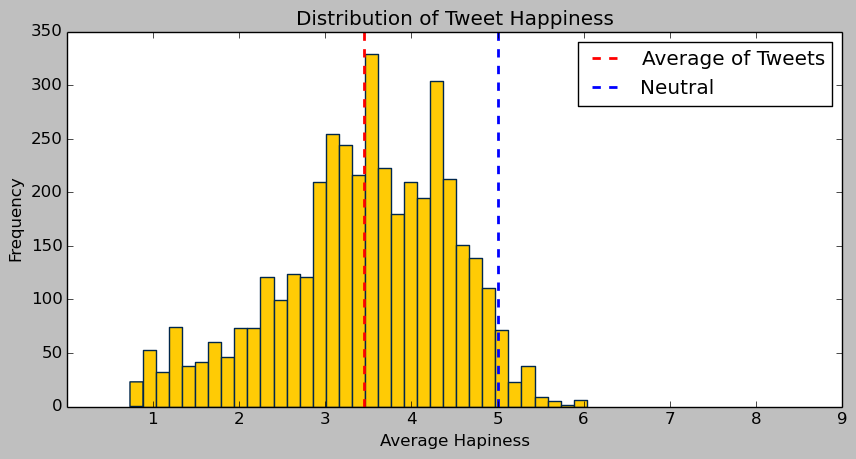

In [179]:
def getHapps(word):
    """Get the happiness valence of a word
    Args:
        word (str): a word
    Returns:
        happs value (float): If the word is in labMT then the hapiness valence will be returned
        False: If the word is absent from labMT then False is returned
    """
    try:
        return labMTBroadcast.value[word]['happs']
    except KeyError:
        return False
    
def getTextHappAvg(text):
    """Calculates the average happiness of a text
    Args:
        text (list): list of tokens in the text
    Returns:
        avgHappiness (float): average happiness score as calculated using 
    """
    tokenFreqDict = termFreq(text)
    freqSum = sum([tokenFreqDict[key] for key in tokenFreqDict.keys()])
    
    tokenHappDict = {token:getHapps(token) for token in text if getHapps(token) != False}
    
    return sum([tokenHappDict[token]*tokenFreqDict[token]/freqSum for token in tokenHappDict.keys()])

tweetsHappiness = (tweetsTokenized
                   .mapValues(getTextHappAvg)
                   .filter(lambda s: s[1] != 0))

import matplotlib.pyplot as plt

tweetsHappsValues = tweetsHappiness.map(lambda s: s[1]).collect()

mean = np.mean(tweetsHappsValues)
median = np.median(tweetsHappsValues)
stdev = np.std(tweetsHappsValues)

fig = plt.figure(figsize=(10,5))
plt.hist(tweetsHappsValues, 35, color='#ffcb05', edgecolor='#00274c')
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label='Average of Tweets')
plt.axvline(5, color='b', linestyle='dashed', linewidth=2, label='Neutral')
plt.title("Distribution of Tweet Happiness")
plt.xticks(range(1,10))
plt.xlabel("Average Hapiness")
plt.ylabel("Frequency")
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend()
plt.savefig(os.path.join('/vagrant/rossImpactTweetsHapps.png'))
pass

print "Happiness mean = %s, median = %s, stdev = %s" % (mean, median, stdev)

In [176]:
topHappTweets = tweetsHappiness.takeOrdered(10, lambda s: -s[1])
topHappTweetsIndicies = [s[0] for s in topHappTweets]
botHappTweets = tweetsHappiness.takeOrdered(10, lambda s: s[1])
botHappTweetsIndicies = [s[0] for s in botHappTweets]

print topHappTweets
print botHappTweets

[(4043, 5.638181818181819), (2499, 5.230666666666666), (689, 5.195), (3164, 5.1475), (2102, 5.1025), (364, 5.062222222222221), (2316, 4.93625), (3894, 4.867272727272726), (664, 4.854000000000001), (2813, 4.814545454545454)]
[(2322, 0.8942857142857145), (629, 0.9000000000000001), (935, 0.92), (3670, 0.9640000000000002), (2083, 1.0), (2100, 1.0), (2191, 1.0), (1091, 1.04), (2921, 1.2225000000000001), (3203, 1.2240000000000002)]


In [177]:
topTweetsText = [tweet[1]['text'] for tweet in noRetweetsRDD.filter(lambda s: s[0] in topHappTweetsIndicies).take(10)]

for tweet in topTweetsText:
    print tweet

I am so impressed with #sec5 the #RossImpact Challenge is before classes; we have so much business knowledge #blessed http://t.co/AuNWv8Ka7j
@POTUS Check out the #RossImpact Challenge #Sec5 is working on to encourage a cultural change with urban youth http://t.co/MPDCMlYgzY
Did not expect to be part of a team helping to write and produce a song inspired by Detroit youth #rossimpact #sec5  https://t.co/bAKzqOo5b4
Thank you @iammikemuse for helping #sec5 crush the #RossImpact challenge! The kids loved it! https://t.co/XgKFGCkJQk
@ times u feel like ur going n circles. But with the right team, u can move n the right direction! #RossImpact #sec5 http://t.co/7nsO7ozNAi
@MichiganRoss Listen! So people know u appreciate their ideas &amp; taking in to account going forward. All want to be valued! #Sec2 #RossImpact
@freep Let's support the #RossImpact Challenge - a positive step towards building tomorrow's Detroit. http://t.co/ifEH8kVRuj #Sec5
Love seeing all the #ROSSIMPACT tweets from our MBA

In [181]:
bottomTweetsText = [tweet[1]['text'] for tweet in noRetweetsRDD.filter(lambda s: s[0] in botHappTweetsIndicies).take(10)]